Benny Cohen

8/2/2020

DAV 6150 Project 3

### Intro

In this notebook we will be looking at a dataset about diamonds provided to us by the DAV 6150 course. We will try to classify the cut of the diamond. 

In order to do this we will examine the features of our dataset, prepare the data, then create 5 types of models: a decision tree, a random forest, a gradient boosting classifier, a stochastic gradient descent classifier, and a XG Boost classifier.

A video summarizing the work can be found at: https://screencast-o-matic.com/watch/cYjnhOENYp

### EDA 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
username = 'cohenb51'
path = 'Katz_School/develop/DAV6150/Project3_Data.csv'
df = pd.read_csv(f'https://raw.githubusercontent.com/{username}/{path}')

In [3]:
df.shape

(53940, 10)

In [4]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

We see that we have 10 columns and 53940 rows. This is a very long, but not very wide dataset. 

The description of the dataset can be found at https://ggplot2.tidyverse.org/reference/diamonds.html

1. price - price in US dollars (326-18,823)

2. carat - weight of the diamond (0.2--5.01)

3. cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)

4. color -  diamond colour, from D (best) to J (worst)

5. clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

6. x - length in mm (0--10.74)

7. y width in mm (0--58.9)

8. z - depth in mm (0--31.8)

9. depth - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

10. table - width of top of diamond relative to widest point (43--95)

A lot of these variables we would think would be correlated with each other. For example, we would think that the higher the price, the larger the diamond would be and the better the cut. When it comes to the feature cut in particular though, the variable we are trying to predict, some of the variables like color logically won't relate to the cut.

In [5]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

None of our features have nulls...

In [6]:
df.head(2)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31


carat, depth, table,price,x,y,and z are all numeric. color, cut and clarity are categorical.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C720099E8>,
      dtype=object)

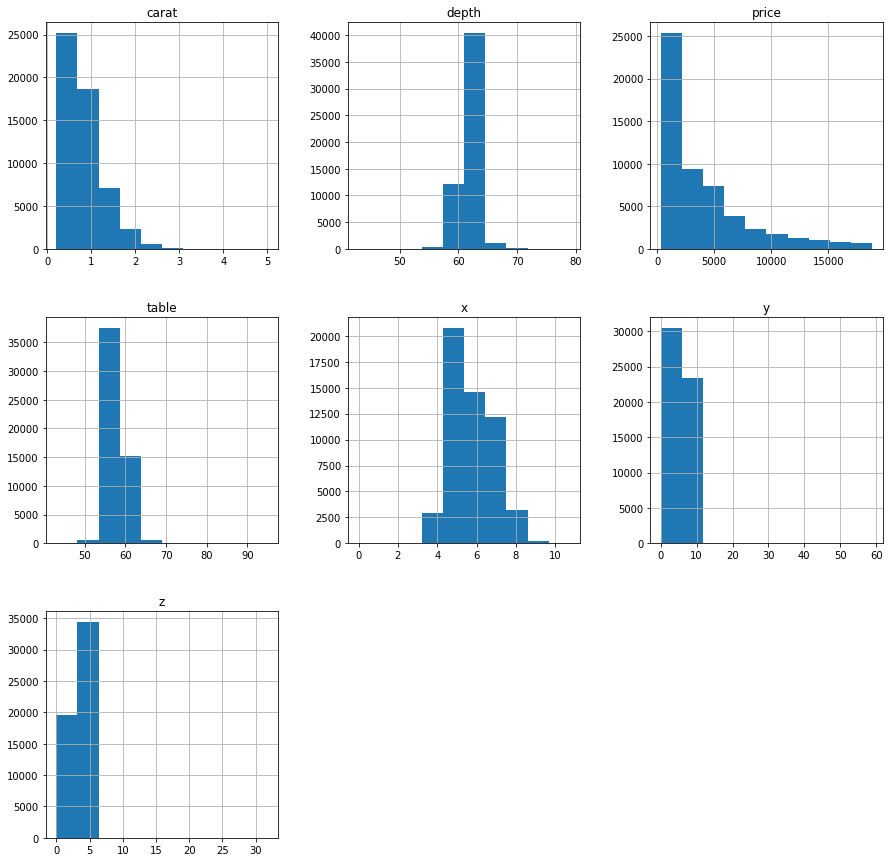

In [7]:
df.hist(figsize = (15,15))

Carat and price are left skewed. depth, table, and z seem to have very large peaks. 

The large peaks for the dimensions indicates that there isn't that much variance but it seems slightly odd that there are outliers stretching the graph out very far. 

In [8]:
(df.z > 7).sum()

2

There are 2 values with a depth > 7. 

In [9]:
(df.y > 15).sum()

2

Likewise 2 values have a very large y.

In [10]:
df[df.z>7]

,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
48410,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80


In [11]:
df[df.y>15]

,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.9,8.06
49189,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.8,5.12


Nothing strikes out about these rows to me other than that there y/z seems to be off by more than a factor of 10. I don't think this will really effect our model if we include them but we might as well drop them since its only 3 records. 

Let's look at correlations.

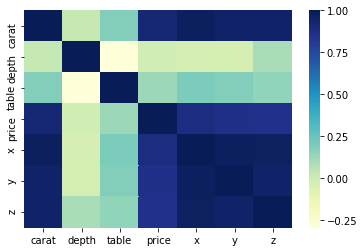

In [12]:
import seaborn as sns
corr = df.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

There is a lot of correlation between our features. 

In particular, we see carat, the weight of the diamond, is highly correlated with the dimensions. Price seems to be most related to the size of the diamond.

In [13]:
corr['carat']

carat    1.000000
depth    0.028224
table    0.181618
price    0.921591
x        0.975094
y        0.951722
z        0.953387
Name: carat, dtype: float64

x,y,z, and price all have correlations of > 90 percent.

Let's look at our categorical variables.

In [14]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [15]:
df.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

This is our target variable. We see that most of our cuts are ideal...

In [16]:
21551/len(df)

0.3995365220615499

Indeed ~40 percent are ideal.

In [17]:
df.color.value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

G,H,E are the most common colors. This is actually an ordinal variable since D indicates best color and each color after that is worse. Most colors seem to be in the middle.

In [18]:
df.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

This is also a ordered categorical variable. From the description above the order is: I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)

We see most values are in the middle.

We will graph these after our data prep step.

In [19]:
df.groupby('cut').mean()

,carat,depth,table,price,x,y,z
cut,,,,,,,
Fair,1.046137,64.041677,59.053789,4358.757764,6.246894,6.182652,3.982770
Good,0.849185,62.365879,58.694639,3928.864452,5.838785,5.850744,3.639507
Ideal,0.702837,61.709401,55.951668,3457.541970,5.507451,5.520080,3.401448
Premium,0.891955,61.264673,58.746095,4584.257704,5.973887,5.944879,3.647124
Very Good,0.806381,61.818275,57.956150,3981.759891,5.740696,5.770026,3.559801


When we group by cut, the most significant difference seems to be carat. The weight of cuts that are simply fair, are around 1 while ideal is around .7

Note that the order of the rows isn't in order (ideal is the 3rd one.)

In [20]:
ideal = df[df.cut == 'Ideal']

In [21]:
ideal.color.value_counts()/len(ideal)

G    0.226625
E    0.181105
F    0.177532
H    0.144541
D    0.131502
I    0.097118
J    0.041576
Name: color, dtype: float64

In [22]:
df.color.value_counts()/len(df)

G    0.209344
E    0.181628
F    0.176900
H    0.153949
D    0.125603
I    0.100519
J    0.052058
Name: color, dtype: float64

It seems like color isn't so predictive of the color as these values are all around the same. This also logically makes sense as color isn't really logically related to how well the person will cut a diamond.

In [23]:
df.clarity.value_counts()/len(df)

SI1     0.242214
VS2     0.227253
SI2     0.170449
VS1     0.151483
VVS2    0.093919
VVS1    0.067760
IF      0.033185
I1      0.013737
Name: clarity, dtype: float64

In [24]:
ideal.clarity.value_counts()/len(ideal)

VS2     0.235302
SI1     0.198691
VS1     0.166535
VVS2    0.120922
SI2     0.120551
VVS1    0.094984
IF      0.056239
I1      0.006775
Name: clarity, dtype: float64

refer: I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)

The percentage of high IF is 2 percent higher and VVS1 is around 3 percent higher. These are pretty big differences since the values had low percentages to start with.

In [25]:
df.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [26]:
_map =   {
    "Ideal" : 1,
    "Premium" : 2,
    "Very Good" : 3,
    "Good" : 4,
    "Fair" : 5,
}

In [27]:
import numpy as np
cuts = df['cut'].map(_map).astype(np.int)

In [28]:
numericalCols = ['carat','depth', 'table', 'price', 'x', 'y','z' ]

In [29]:
import scipy.stats as stats

for col in numericalCols:
    print(df[col].dtype)
    print(f'{col} has a point berialr score of {stats.pointbiserialr(cuts,df[col])}')

float64
carat has a point berialr score of PointbiserialrResult(correlation=0.13496702034499986, pvalue=1.208755362668952e-217)
float64
depth has a point berialr score of PointbiserialrResult(correlation=0.21805500914169046, pvalue=0.0)
float64
table has a point berialr score of PointbiserialrResult(correlation=0.4334046064814475, pvalue=0.0)
int64
price has a point berialr score of PointbiserialrResult(correlation=0.053490660868104445, pvalue=1.7561033962459248e-35)
float64
x has a point berialr score of PointbiserialrResult(correlation=0.12556523668377842, pvalue=1.9902338235587208e-188)
float64
y has a point berialr score of PointbiserialrResult(correlation=0.12146186675248602, pvalue=2.3418780284033194e-176)
float64
z has a point berialr score of PointbiserialrResult(correlation=0.14932253650521551, pvalue=1.7784976346778246e-266)


The closer this score is to 1, the more the correlation. We see that table, the max width of the diamond seems to have the highest. The other scores are lower but still indicate there is a correlation.

### EDA Summary:
        Our target variable cut has around 40 percent ideal. The better cuts all have higher frequency. 
        Our target variable is correlated with most of our other features. 
        Many of our numerical variables are correlated with each other.

### Data Prep

PCA would reduce multicollinearity but in our case I don't think it is such a big problem to be including features that are collinear for decision trees/boosting. The tree will just split on 1 of the 2 features. Additionally, high dimensionality is not a problem in our dataset. We only have 9 features. 

Since all of our Point biserialar Result scores were positive and we had so many records it is unlikely that those correlations are not insignificant. I therefore will use all the numerical variables. Although the numerical features are on different scales, we don't need to standardize as our boosting algorithms don't require standardization. 

We need to ordinal encode our clarity variable though. Color we will drop as we saw from our eda isn't so insightful.

In [30]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [31]:
df.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

Recall - I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

In [32]:
_map =   {
    "I1" : 1,
    "SI2" : 2,
    "SI1" : 3,
    "VS2" : 4,
    "VS1" : 5,
    "VVS2" :6,
    "VVS1" : 7,
    "IF" : 8,
}

In [33]:
df['clarity'] = df['clarity'].map(_map).astype(int)

Let's drop the outlier rows we mentioned earilier. This isn't strictly needed since tree models are robust to outliers but it will make the data cleaner.

In [35]:
df.drop([49189, 24067,48410], inplace = True)

In [36]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

If we had a lot of features it might make sense to drop features but since we only have 10 we should keep the features even if they have multicollinearity since our models can deal with that.

I will drop the color feature though since we saw in our eda that there is no significant difference with this column.

In [37]:
df = df.drop('color', axis = 1)

### Prepped Data Review

The only change we made was using an ordinal encoder to convert the color column.

In [39]:
df['clarity'].value_counts()

3    13065
4    12258
2     9193
5     8169
6     5066
7     3655
8     1790
1      741
Name: clarity, dtype: int64

Comparing these too the numbers we saw above in our eda we see that these numbers match.

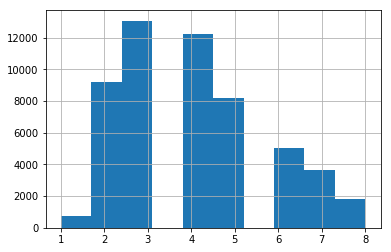

In [40]:
df['clarity'].hist()

We also see like we did in our eda that most clarity is towards the center.

### Model Building

We will use the same features in all of our models... Our main job then is to try to find the best hyperparameters.

### Decision Tree

In [42]:
from sklearn.model_selection import train_test_split
y = df['cut']
x= df.drop(['cut'], axis = 1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.tree import DecisionTreeClassifier
rf = DecisionTreeClassifier()
rf.fit(X_train, y_train)

DecisionTreeClassifier()

In [45]:
scores = rf.predict(X_train)

In [46]:
import sklearn.metrics as metrics

metrics.accuracy_score(y_train,scores)

0.9998609469512619

Our accuracy score with the default parameters are really good. We should be cognizant of overfitting though.

In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.71390498, 0.70556199, 0.70196987, 0.70996524, 0.70378955])

Our cross val scores are much lower. This tells us that we are heavily overfitting. We could try to improve this by changing the max depth of the tree so we don't predict all the way on the leaf level.

In [ ]:
param_grid = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(),param_grid, cv = 5)
res = grid.fit(X_train,y_train)

In [ ]:
res.best_param_

Our best score was with a max depth of 11 so let's try retraining with these values.

In [48]:
rf = DecisionTreeClassifier(max_depth = 11)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.74217845, 0.74345307, 0.75144844, 0.75098494, 0.73971491])

Our scores are around 4 percent higher. 

In [49]:
rf.fit(X_train, y_train)
scores = rf.predict(X_train)

In [50]:
metrics.accuracy_score(y_train,scores)

0.7727409673457091

Now our accuracy score is closer to what we see with cross validation. This seems to be the best number of leaves to minimize overfitting.

Let's get other common metrics for classification models.

In [53]:
print(metrics.classification_report(y_train,scores))

              precision    recall  f1-score   support

        Fair       0.96      0.93      0.94      1279
        Good       0.88      0.70      0.78      3906
       Ideal       0.83      0.92      0.87     17192
     Premium       0.67      0.84      0.75     11056
   Very Good       0.72      0.44      0.55      9716

    accuracy                           0.77     43149
   macro avg       0.81      0.77      0.78     43149
weighted avg       0.77      0.77      0.76     43149



Our scores shows that this model is really good at predicting fair cuts but struggles at identifying very good as it's recall score for that variable is only around .44

### Random Forest

Random Forest is an ensemble method which looks at multiple decision trees. We might expect this to overfit less than decision trees.

I will start by using the default parameters as a baseline then adjust the parameters to try to find the best ones.



In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, random_state=123456)
rf.fit(X_train, y_train)
scores = rf.predict(X_train)

In [55]:
metrics.accuracy_score(y_train,scores)

0.9992815592481865

Our accuracy is close to 1, like we saw with our decision trees.

In [56]:
rf = RandomForestClassifier(n_estimators=50)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.7787949 , 0.7760139 , 0.78146002, 0.77682503, 0.77506084])

Our cross val scores are around 20 percent lower than our accuracy. These scores though are still higher than our base decision tree model. Let's try changing min_samples_leaf. This should prevent our trees from going all the way down to overfit the model. We won't use grid search since this is more computationally expensive.

In [204]:
rf = RandomForestClassifier(min_samples_leaf=50)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.74495944, 0.73951333, 0.74368482, 0.75086906, 0.74353923])

Perhaps this value is too high as it made our score go down.

In [58]:
rf = RandomForestClassifier(min_samples_leaf=15)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.76141367, 0.76095017, 0.7622248 , 0.76280417, 0.76231313])

Increasing leaves past 15 seems to make our scores low. Let's choose 3

In [59]:
rf = RandomForestClassifier(min_samples_leaf=3)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.77775203, 0.77682503, 0.78470452, 0.77717265, 0.7774945 ])

These scores are slightly higher. This seems like a better value to use. Let's see if these scores match up to what we would get if we use min_samples = 5.

As before let's get the classification summary.

In [65]:
rf = RandomForestClassifier(min_samples_leaf=5)
rf.fit(X_train, y_train)
scores = rf.predict(X_train)

In [66]:
print(metrics.classification_report(y_train,scores))

              precision    recall  f1-score   support

        Fair       0.94      0.89      0.91      1279
        Good       0.91      0.78      0.84      3906
       Ideal       0.85      0.94      0.89     17192
     Premium       0.85      0.88      0.87     11056
   Very Good       0.85      0.70      0.77      9716

    accuracy                           0.86     43149
   macro avg       0.88      0.84      0.86     43149
weighted avg       0.86      0.86      0.85     43149



Even with min_samples_leaf 5 our scores still show we are overfitting. (accuracy of .86).
We could try raising this number a bit more.

In [69]:
rf = RandomForestClassifier(min_samples_leaf=8)
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores

array([0.77056779, 0.76940904, 0.77473928, 0.76940904, 0.77158419])

In [191]:
rf = RandomForestClassifier(min_samples_leaf=8)
rf.fit(X_train, y_train)
scores = rf.predict(X_train)

In [192]:
metrics.accuracy_score(y_train,scores)

0.8264386196667362

In [68]:
print(metrics.classification_report(y_train,scores))

              precision    recall  f1-score   support

        Fair       0.92      0.86      0.89      1279
        Good       0.87      0.73      0.79      3906
       Ideal       0.83      0.94      0.88     17192
     Premium       0.81      0.86      0.84     11056
   Very Good       0.81      0.63      0.71      9716

    accuracy                           0.83     43149
   macro avg       0.85      0.80      0.82     43149
weighted avg       0.83      0.83      0.82     43149



I think this value is the best choice as our cross val scores are not significantly lower than our trained model. 
Also we see these scores as a whole are better than our tree model with an weighted f1 score of all of our features around .82. The recall score for very good which was .44 in the tree model is up to .63 in this model.

### Gradient Boosting

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

Boosting is a technique that uses multiple weak learners to make a model. Let's start by using 100 weak learners and deep trees with a learning rate of 1.

In [71]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7182981090100111

In [72]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.71436848, 0.71123986, 0.72201622, 0.70776362, 0.70344188])

sklearn provides several parameters described here 
https://docs.w3cub.com/scikit_learn/modules/generated/sklearn.ensemble.gradientboostingclassifier/

One thing we can try is increasing the max depth to capture more information. We could also try seeing if reducing the number of trees leads to faster performance.

In [205]:
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=10, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.10567296996662959

Although this is faster, our accuracy is around the same. Let's see how many estimators we can use without sacraficing performance.

In [75]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1.0, max_depth=10, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7270114942528736

This is much faster and does slightly better.

The learning rate tells us how much each tree is contributing. We could try lowering the learning rate.

In [76]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=.7, max_depth=10, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7594549499443827

We are noticing by lowering the learning rate and the number of trees, our model is improving. 

In [85]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=.4, max_depth=10, random_state=0).fit(X_train, y_train)

In [92]:
scores = clf.predict(X_train)
metrics.accuracy_score(y_train, scores)

0.955433497879441

In [79]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.77022016, 0.77404403, 0.77670915, 0.77914253, 0.77193186])

We are overfiting a bit through. We could try lowering the max depth.

In [98]:
clf = GradientBoostingClassifier(n_estimators=20, learning_rate=.4, max_depth=8, random_state=0).fit(X_train, y_train)

In [99]:
scores = clf.predict(X_train)
metrics.accuracy_score(y_train, scores)

0.8815268024751443

In [100]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.78146002, 0.78180765, 0.78435689, 0.77670915, 0.77332252])

This seems like the best version of the model since now our we aren't overfitting as much and we can be more certain it will perform with less variance on new data. 

Let's get all the scores.

In [101]:
scores = clf.predict(X_train)

In [102]:
print(metrics.classification_report(y_train,scores))

              precision    recall  f1-score   support

        Fair       0.98      0.87      0.92      1279
        Good       0.92      0.87      0.89      3906
       Ideal       0.88      0.96      0.91     17192
     Premium       0.88      0.90      0.89     11056
   Very Good       0.86      0.74      0.80      9716

    accuracy                           0.88     43149
   macro avg       0.91      0.87      0.88     43149
weighted avg       0.88      0.88      0.88     43149



This model seems slightly better than the forest as all the f1 scores are above .8

### Stochastic Gradient Descent Classifier

This is a variant of gradient descent where instead of evaluating a whole batch of data it looks at a single training sample and makes progress at each iteration.

Gradient Descent requires variables to be normalized.

In [131]:
from sklearn.preprocessing import MinMaxScaler


In [160]:
scaler = MinMaxScaler()
X_train_f = scaler.fit_transform(X_train)

In [162]:
X_train_f = pd.DataFrame(X_train_f)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020C112A4DA0>,
      dtype=object)

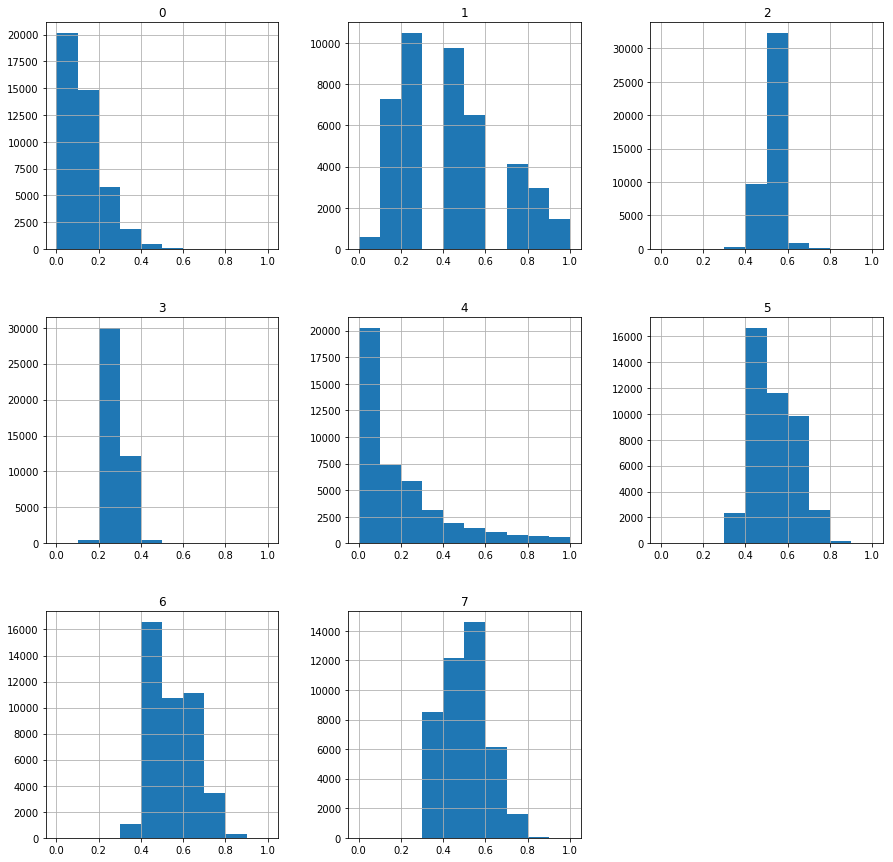

In [163]:
X_train_f.hist(figsize = (15,15))

Our distributions are now between 0 and 1 except the categorical feature.

In [167]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier().fit(X_train_f, y_train)
clf.score(X_train_f, y_train)

0.551252636214049

 The model with the default parameters does not seem to be doing so well. 

In [168]:
clf.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

 Alpha is both a regularisation parameter and the initial learning rate. We could try finding the best value for alpha with grid search as this is a faster algorithm.

In [169]:
param_grid = {'alpha': [.001, .01, .1, 1, 10, 100]}

In [ ]:
grid = GridSearchCV(SGDClassifier(),param_grid, cv = 5)
res = grid.fit(X_train,y_train)

In [ ]:
res.best_params_

alpha of .01 gives us the best score.

In [171]:
clf = SGDClassifier(alpha = .01).fit(X_train, y_train)
clf.score(X_test, y_test)

0.41286614757137563

In [172]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.28574739, 0.42653534, 0.23904983, 0.43487833, 0.10232935])

This model as a whole doesn't seem to be doing well. Let's get all the statistics.

In [173]:
scores = clf.predict(X_train)

In [174]:
print(metrics.classification_report(y_train,scores))

C:\Users\b-coh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Fair       0.00      0.00      0.00      1279
        Good       0.00      0.00      0.00      3906
       Ideal       0.41      1.00      0.58     17192
     Premium       0.38      0.04      0.07     11056
   Very Good       0.00      0.00      0.00      9716

    accuracy                           0.41     43149
   macro avg       0.16      0.21      0.13     43149
weighted avg       0.26      0.41      0.25     43149



C:\Users\b-coh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\b-coh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see that the model actually just seems to be predicting everything as ideal or premium. This model doesn't seem to be so usable,

### XG BoostClassifier

XGBoost is another implementation of boosting which has different regularization methods and has some degree of parallelism.

In [175]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train,y_train)
  
preds = model.predict(X_train)
model.score(X_test, y_test)


0.803299962921765

This model's accuracy seems about in the middle of the other models. Because xgboost has regularization, we would expect the cross val scores to be good if our default values are fine.

In [176]:
scores = cross_val_score(model, X_train, y_train, cv=5)
scores

array([0.79918888, 0.79837775, 0.79930475, 0.79455388, 0.79244408])

We could still explore though what would happen if we play with the hyper parameters. Gamma sets the minimum loss reduction to make a split.

In [177]:
model = XGBClassifier(gamma = .01)
model.fit(X_train,y_train)
  
preds = model.predict(X_train)
model.score(X_test, y_test)

0.8017241379310345

In [178]:
model = XGBClassifier(gamma = 1)
model.fit(X_train,y_train)
  
preds = model.predict(X_train)
model.score(X_test, y_test)

0.8001483129403041

This doesn't seem to make so much of a difference.

We could also change the number of leaves like before.

In [179]:
model = XGBClassifier(max_depth = 3)
model.fit(X_train,y_train)
  
preds = model.predict(X_train)
model.score(X_test, y_test)

0.7776232851316277

Increasing the max depth makes our model do worse.I think we saw from the cross validation the default parameters are good.

In [188]:
model.fit(X_train,y_train)
  
preds = model.predict(X_train)

In [189]:
metrics.accuracy_score(y_train,preds)

0.7850471621590304

In [181]:
print(metrics.classification_report(y_train,preds))

              precision    recall  f1-score   support

        Fair       0.93      0.91      0.92      1279
        Good       0.84      0.68      0.75      3906
       Ideal       0.82      0.92      0.87     17192
     Premium       0.73      0.85      0.78     11056
   Very Good       0.73      0.50      0.59      9716

    accuracy                           0.79     43149
   macro avg       0.81      0.77      0.78     43149
weighted avg       0.78      0.79      0.78     43149



Our f1 score is around .8 but the main advantage this model has was that the scores already seemed to be regulated and it performed very well on cross validation so it will likely do well on new data.

### Model Comparison.

Let's make a table of the avg scores from each model.

| Model                       | Accuracy                        | Precision | Recall  | F1-score |
|-----------------------------|---------------------------------|-----------|---------|----------|
| Decision Tree               | .77                             | .76       | .77     | .76      |
| Random Forest               | .83                             | .86       | .86     | .85      |
| Gradient Boosting           | .88 (.78 when cross validating) | .88       | .88     | .88      |
| Stochastic Gradient Descent | .41                             | .26       | .41     | .25      |
| XG Boost                    | .78                             | .78       | .79     | .78      |

In terms of comparing the models, most of the models performed very similarly with accuracy scores a bit under .8. The exception to this was stochastic gradient descent which had low scores for all the metrics.

In terms of choosing which model, we gradient boosting had the best scores with an overall recall score of .88. We also saw though that when we used cross validation, its scores were around .78.

I therefore think that the next best choice is random forest which we saw had an f1 score of .85. The downside which I should point out is that this model may be a bit slower if we need to use the model in real time. The other down side was this model did not have a very good f1 score when predicting the diamonds with very good cuts.

### Test Data.

In [194]:
rf = RandomForestClassifier(min_samples_leaf=8)
rf.fit(X_train, y_train)
scores = rf.predict(X_test)

In [195]:
metrics.accuracy_score(scores, y_test)

0.7801260659992585

In [197]:
print(metrics.classification_report(y_test,scores))

              precision    recall  f1-score   support

        Fair       0.90      0.88      0.89       331
        Good       0.80      0.65      0.72      1000
       Ideal       0.82      0.93      0.87      4358
     Premium       0.74      0.83      0.78      2734
   Very Good       0.71      0.48      0.57      2365

    accuracy                           0.78     10788
   macro avg       0.79      0.76      0.77     10788
weighted avg       0.77      0.78      0.77     10788



Our scores are slightly lower. While on the training data we had an f1 score of around .85 on the test data it is around .77-.78

Conclusions

1. We saw from our EDA that many of our features were correlated, although the correlations were weaker with the cut variable.
2. All of our models performed similarly with the exception of stochastic gradient descent which performed worse.
3. Our random tree, forest, and gradient boosting algorithm required a lot of parameter tuning to minimize overfitting.
4. The end model we chose, the random forest, was able to achieve an f1 and accuracy score around 78 percent. This model is good enough to accurately predict the type of cut. 